#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [1]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import TimeSeriesSplit


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
# меняем типа данных с object на datetime64 
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])
pd.to_datetime(df['datetime'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


In [5]:
# устанавливаем индекс таблицы равный datetime 
df.set_index('datetime', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.index.is_monotonic

True

In [7]:
# проводим ресемплирование по одному часу 
df = df.resample('1H').sum() 
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

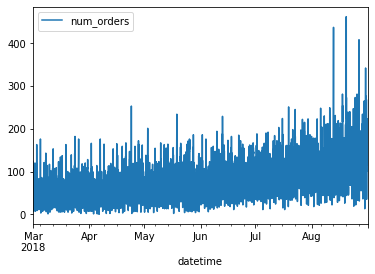

In [8]:
# визуализируем диаграмму временного ряда 
df.plot()

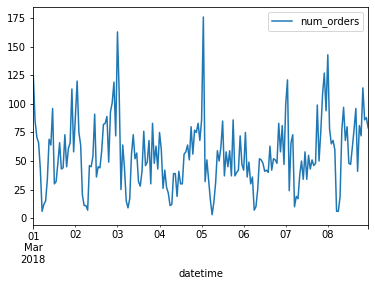

In [9]:
# динамика поездок за период одна неделя 
df['2018-03-01':'2018-03-8'].plot()
plt.show()

Динамика количество поездок по дням недели не меняется, количесвто поездок по часам примерно одинаковое независимо от дня недели  

Данные готовы для анализа 

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Анализ данных 

In [10]:
# найдем и визуализируем скользящую средню и скользящее стандартное отклоненение 
df["rolling_mean"] = df["num_orders"].rolling(20).mean()
df["rolling_std"] = df["num_orders"].rolling(20).std()

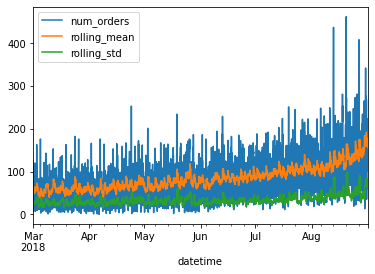

In [11]:
df.plot()
plt.show()

In [12]:
# разберем тренд данных и фактор сезонности 
decomposed = seasonal_decompose(df['num_orders']) 

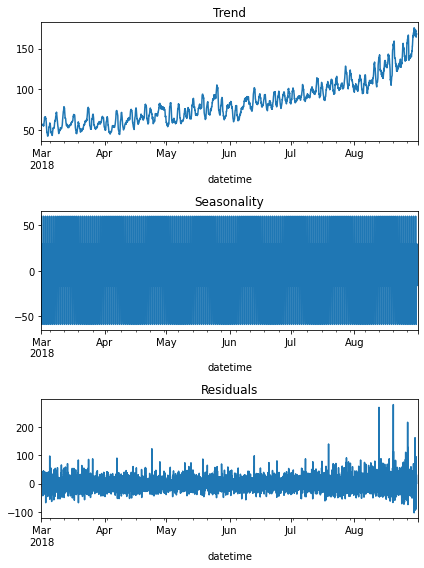

In [13]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

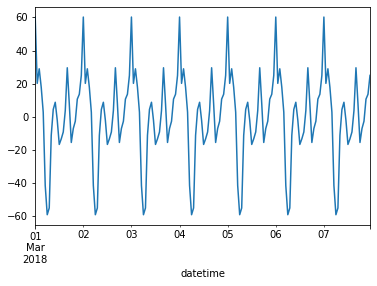

In [14]:
# строим график сезонной составляющей за первую неделю марта 
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.show()

Вывод: 

- По итогам анализа данных мы видим восходящий тренд среднего количества поездок в течении года, а также циклично повторяющиеся закономерности seasonality. 
- Поскольку меняется среднее значение, то данный временной ряд нестационарный и пока его прогнозирование не может быть точным 
- Для того чтобы сделать ряд стационарным необходимо найти значения разности его значений 

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

<AxesSubplot:xlabel='datetime'>

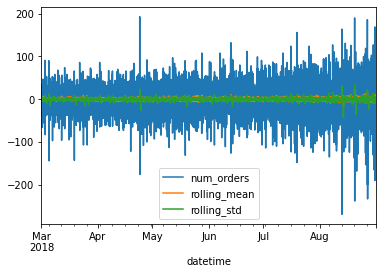

In [15]:
df = df - df.shift() 

df.plot()

In [16]:
df.describe()

,num_orders,rolling_mean,rolling_std
count,4415.000000,4396.000000,4396.000000
mean,0.018347,0.024488,0.006832
std,39.023437,2.801253,2.696896
min,-269.000000,-16.650000,-42.969300
25%,-22.000000,-1.750000,-0.718874
50%,1.000000,-0.050000,0.001940
75%,23.000000,1.650000,0.753557
max,193.000000,21.800000,33.294242


В результате преобразования данных временной ряд стал более стационарен - данные можно прогнозировать

### Создание признаков 

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
make_features(df, 24, 20)

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

## Обучение моделей

In [19]:
# создаем обучающую и тестовые выборки 

train, test = train_test_split(df, shuffle = False, test_size = 0.1) 
train= train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
                                                                           

Для оценки качества предсказания моделей будем использовать метрику - Mean Absolute Error 

In [20]:
# LinearRegression
model = LinearRegression() 
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}

model.fit(features_train, target_train) 


LinearRegression()

In [21]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)

# CatBoost
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 42)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(features_train, target_train),cv= splits,verbose=True)

0:	learn: 32.4338574	test: 45.0894762	best: 45.0894762 (0)	total: 54.4ms	remaining: 54.4s
1:	learn: 31.5590692	test: 44.2733070	best: 44.2733070 (1)	total: 59.1ms	remaining: 29.5s
2:	learn: 30.8645308	test: 43.7155318	best: 43.7155318 (2)	total: 63.1ms	remaining: 21s
3:	learn: 30.2322207	test: 43.1596588	best: 43.1596588 (3)	total: 67ms	remaining: 16.7s
4:	learn: 29.5871888	test: 42.5009788	best: 42.5009788 (4)	total: 71.2ms	remaining: 14.2s
5:	learn: 29.2724949	test: 42.2242328	best: 42.2242328 (5)	total: 73.6ms	remaining: 12.2s
6:	learn: 28.8723766	test: 41.7891341	best: 41.7891341 (6)	total: 78.1ms	remaining: 11.1s
7:	learn: 28.4037039	test: 41.2805238	best: 41.2805238 (7)	total: 83.4ms	remaining: 10.3s
8:	learn: 28.0581010	test: 40.9690776	best: 40.9690776 (8)	total: 88.1ms	remaining: 9.7s
9:	learn: 27.7219276	test: 40.7162137	best: 40.7162137 (9)	total: 92.3ms	remaining: 9.14s
10:	learn: 27.4287256	test: 40.4594512	best: 40.4594512 (10)	total: 96.9ms	remaining: 8.71s
11:	learn: 27

<div class="alert alert-block alert-warning">

Замечание понятно! Изучил в документации библиотеки sklearn функцию TimeSeriesSplit для разделения образцов даных временных рядов, импортировал в проект и изменил код соответственно.   

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Отлично, молодец!
</div>

In [22]:
# LightGBM
lgb_train = lgb.Dataset(features_train, target_train)
lgb_test = lgb.Dataset(features_test,target_test, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train,lgb_test],
                verbose_eval=100)



/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5009
[LightGBM] [Info] Number of data points in the train set: 3949, number of used features: 29
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.007344
[100]	training's l2: 125.078	valid_1's l2: 1542.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [23]:
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train, target_train))

0:	learn: 35.2219068	total: 4.41ms	remaining: 4.41s
100:	learn: 20.7725653	total: 440ms	remaining: 3.91s
200:	learn: 16.7034043	total: 880ms	remaining: 3.5s
300:	learn: 14.3222002	total: 1.3s	remaining: 3.02s
400:	learn: 12.5928800	total: 1.71s	remaining: 2.55s
500:	learn: 11.2878812	total: 2.11s	remaining: 2.11s
600:	learn: 10.1281112	total: 2.52s	remaining: 1.67s
700:	learn: 9.2472571	total: 2.95s	remaining: 1.26s
800:	learn: 8.4701980	total: 3.36s	remaining: 836ms
900:	learn: 7.7704093	total: 3.78s	remaining: 416ms
999:	learn: 7.1595514	total: 4.2s	remaining: 0us


In [24]:
# находим предсказания на тренировочной выборке 
# LinearRegression
preds_LR_train = model.predict(features_train)
# CatBoost
preds_Cat_train = final_cat.predict(features_train)
#LightGBM
preds_Light_train = light.predict(features_train)


In [25]:
# находим MAE моделей на тренировочной выборке 
# LinearRegression
RMSE_LR_train = (mean_squared_error(target_train,preds_LR_train))**0.5
# CatBoost
RMSE_CatBoost_train = (mean_squared_error(target_train,preds_Cat_train))**0.5
#LightGBM
RMSE_LightGBM_train = (mean_squared_error(target_train,preds_Light_train))**0.5


## Тестирование

In [26]:
# находим предсказания на тестовой выборке 

# LinearRegression
preds_LR_test = model.predict(features_test)
# CatBoost
preds_Cat_test = final_cat.predict(features_test)
#LightGBM
preds_Light_test = light.predict(features_test)


In [27]:
# находим RMSE моделей на тестовой выборке

# LinearRegression
RMSE_LR_test = (mean_squared_error(target_test,preds_LR_test))**0.5
# CatBoost
RMSE_CatBoost_test = (mean_squared_error(target_test,preds_Cat_test))**0.5
#LightGBM
RMSE_LightGBM_test = (mean_squared_error(target_test,preds_Light_test))**0.5


In [28]:
# формируем сводную таблицу по итогам исследования  
report = pd.DataFrame(columns = ["LinearRegression","CatBoost","LightGBM"],
                      index = ["RMSE_train","RMSE_test"])


report.iloc[0] = [RMSE_LR_train,RMSE_CatBoost_train,RMSE_LightGBM_train]
report.iloc[1] = [RMSE_LR_test,RMSE_CatBoost_test,RMSE_LightGBM_test]


In [29]:
display(report) 

,LinearRegression,CatBoost,LightGBM
RMSE_train,24.672519,7.159551,0.329058
RMSE_test,43.881968,36.01711,37.96431


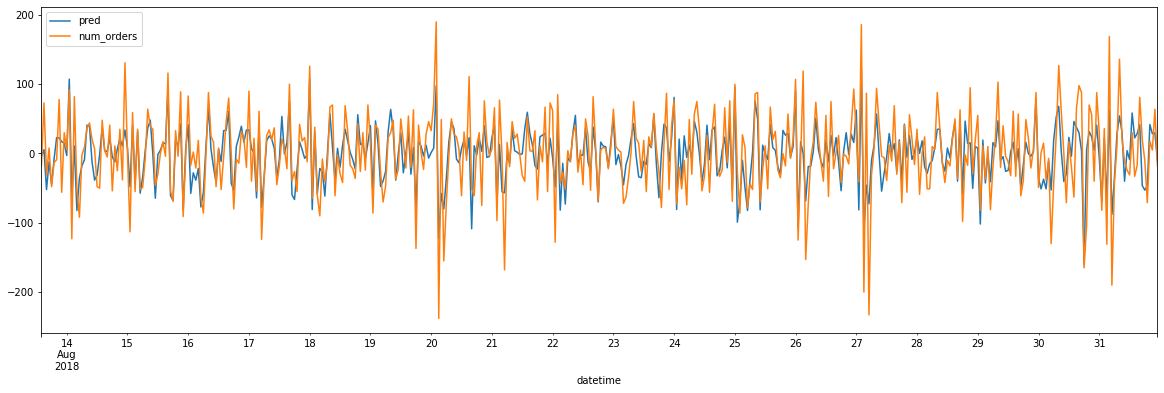

In [50]:
# график изначальных данных на тестовой выборке и предсказаний модели LightGBM 
pred = pd.DataFrame(preds_Light_test)
pred.rename(columns={0:'pred_orders'}, inplace =True)
data_test = pd.DataFrame(test['num_orders'])
data_test['pred'] = pred['pred_orders'].values
x= data_test[['pred','num_orders']]
x.plot(figsize=(20,6))
plt.show()

Вывод: 

Наименьшую ошибку на тренировочной выборке дают модели Градиентного бустинга - CatBoost и LightGBM - они больше соответствуют исследованию данных временного ряда. Обычная Линейная регрессия хуже cпрогнозировала целевой признак. На тестовой выборке у всех трех моделей ошибка выше, но в допустимых пределах. (см. сводную таблицу). Для визуализации полученного результата представлена диаграма с тестовой выборкой изначальных данных и данных, которые были предсказаны моделью LightGBM.



## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48